In [1]:
import os
spark_home = "/opt/spark"
os.environ["PYSPARK_PYTHON"] = "python3"
os.environ["SPARK_HOME"] = spark_home
os.environ["SPARK_CLASSPATH"] = "/opt/spark/jars/sqljdbc4.jar"

from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("ClassDensityData_Spark") \
    .getOrCreate()

In [2]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.types import *
from pyspark.sql.functions import *
import traceback
from pyspark.sql.window import Window
from pyspark.ml.feature import Bucketizer

# from pyspark.sql import SQLContext
sqlContext = pyspark.SQLContext(spark)
%matplotlib inline

In [4]:
def ClassDensityData_Spark (*, dataframe, inputCol, classCol=None, bins=None):
    
    # * --> is to force using keyword arguments (takes 0 positional arguments)
    # dataframe --> Input dataframe
    # inputCol --> input column name
    # classCol (optional) --> column name to be considered for class (default=None)
    # bins (optional) --> number of bins to be provided (default=10)
    
    try:
        df = dataframe
        i_col = str(inputCol)
        c_col = classCol
        x_bins = None

        if bins is not None:
            x_bins = int(bins)
        else:
            x_bins = int(10)

        dtype = dict(df.dtypes)[i_col]

        if (dtype == 'int') | (dtype == 'double'):

            if c_col == None:
                df = df.select(i_col)
                df = df.groupBy(i_col).count()

                max_value = df.agg({i_col : "max"}).collect()[0][0]
                min_value = df.agg({i_col : "min"}).collect()[0][0]
                diff = (max_value - min_value)/x_bins
                
                split_array = np.arange(min_value, max_value, diff)
                split_list = list(split_array)
                split_list.append(max_value)

                x_array = np.array(split_list)
                # Middle point of each pair of an numpy.array
                x_array = (x_array[1:] + x_array[:-1]) / 2
                x_list = list(x_array)
                x_list = [float(item) for item in x_list]
                # print(type(x_list[0]))

                bucketizer = Bucketizer(splits=split_list, inputCol=i_col, outputCol="buckets")
                df_buck = bucketizer.setHandleInvalid("keep").transform(df)
                df_buck = df_buck.groupBy('buckets').sum('count')
                df_buck = df_buck.orderBy(col('buckets').asc())
                df_buck = df_buck.withColumn('Density', col("sum(count)")/sum("sum(count)").over(Window.partitionBy()))

                # Convert x_list to a dataframe
                x_df = sqlContext.createDataFrame([(l,) for l in x_list], ['x_values'])

                # Joining x_df with df_buck
                df_buck = df_buck.withColumn("idx", monotonically_increasing_id())
                x_df = x_df.withColumn("idx", monotonically_increasing_id())

                windowSpec = Window.orderBy("idx")
                df_buck = df_buck.withColumn("idx", row_number().over(windowSpec))
                x_df = x_df.withColumn("idx", row_number().over(windowSpec))

                final_df = df_buck.join(x_df, df_buck.idx == x_df.idx).drop("idx")
                df_xy = final_df.select(col('x_values').alias(i_col), col('Density'))
                
                return df_xy

            elif c_col is not None:
                c_df = df.groupBy(c_col).count().orderBy(col('count').desc())
                c_list = list(c_df.select(c_col).toPandas()[c_col])

                l = len(c_list)

                # Empty spark dataframe to append final columns, class-wise!!
                emptySchema = StructType()
                df_final = spark.createDataFrame([], emptySchema)

                for i in range(0,l):
                    idx = i
                    x = c_list[i]
                    x_col = str(i_col+'_'+x)
                    df_i = df.filter(col(c_col)==x).select(col(i_col).alias(x_col))
                    df_i = df_i.groupBy(x_col).count()

                    max_value = df_i.agg({x_col : "max"}).collect()[0][0]
                    min_value = df_i.agg({x_col : "min"}).collect()[0][0]
                    diff = (max_value - min_value)/x_bins

                    split_array = np.arange(min_value, max_value, diff)
                    split_list = list(split_array)
                    split_list.append(max_value)

                    x_array = np.array(split_list)
                    # Middle point of each pair of an numpy.array
                    x_array = (x_array[1:] + x_array[:-1]) / 2
                    x_list = list(x_array)
                    x_list = [float(item) for item in x_list]
                    # print(type(x_list[0]))

                    bucketizer = Bucketizer(splits=split_list, inputCol=x_col, outputCol="buckets")
                    df_buck = bucketizer.setHandleInvalid("keep").transform(df_i)
                    df_buck = df_buck.groupBy('buckets').sum('count')
                    df_buck = df_buck.orderBy(col('buckets').asc())
                    df_buck = df_buck.withColumn('Density', col("sum(count)")/sum("sum(count)").over(Window.partitionBy()))

                    # Convert x_list to a dataframe
                    x_df = sqlContext.createDataFrame([(l,) for l in x_list], ['x_values'])

                    # Joining x_df with df_buck
                    df_buck = df_buck.withColumn("idx", monotonically_increasing_id())
                    x_df = x_df.withColumn("idx", monotonically_increasing_id())

                    windowSpec = Window.orderBy("idx")
                    df_buck = df_buck.withColumn("idx", row_number().over(windowSpec))
                    x_df = x_df.withColumn("idx", row_number().over(windowSpec))

                    df_xy = df_buck.join(x_df, df_buck.idx == x_df.idx).drop("idx")

                    y_col = str('Density_'+x)
                    df_xy = df_xy.select(col('x_values').alias(x_col), col('Density').alias(y_col))

                    # Joining df_xy with df_final
                    df_final = df_final.withColumn("idx", monotonically_increasing_id())
                    df_xy = df_xy.withColumn("idx", monotonically_increasing_id())

                    windowSpec = Window.orderBy("idx")
                    df_final = df_final.withColumn("idx", row_number().over(windowSpec))
                    df_xy = df_xy.withColumn("idx", row_number().over(windowSpec))

                    df_final = df_final.join(df_xy, df_final.idx == df_xy.idx, 'rightouter').drop("idx")

                return df_final

        else:
            print('InputError: Input column is not a NumericType')
            
        return
    
    except Exception as e:
        print(e)

In [3]:
# Loading spark dataframe as 'df'
df_path = "/home/rupeshr/Desktop/TSA_Python/dataset/time series dataset/archive/monthly-beer-production-in-austr.csv"
df = spark.read.format("com.databricks.spark.csv").option("header", "true").option("inferSchema", "true").load(df_path)
df.show(1)

+-------+-----------------------+
|  Month|Monthly beer production|
+-------+-----------------------+
|1956-01|                   93.2|
+-------+-----------------------+
only showing top 1 row



In [5]:
df1 = ClassDensityData_Spark(dataframe=df, inputCol="Monthly beer production", classCol=None, bins=10)
df1.show()

Py4JJavaError: An error occurred while calling o140.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 6 in stage 17.0 failed 1 times, most recent failure: Lost task 6.0 in stage 17.0 (TID 1025, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 477, in main
    ("%d.%d" % sys.version_info[:2], version))
Exception: Python in worker has different version 3.7 than that in driver 3.6, PySpark cannot run with different minor versions. Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:503)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:638)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:456)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:489)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage7.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:729)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:462)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:465)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2008)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2007)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2007)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:973)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2239)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2188)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2177)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:775)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2114)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2135)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2154)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:472)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:425)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:47)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3627)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2697)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3618)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:100)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:160)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:87)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:764)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3616)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2697)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2904)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:300)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:337)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 477, in main
    ("%d.%d" % sys.version_info[:2], version))
Exception: Python in worker has different version 3.7 than that in driver 3.6, PySpark cannot run with different minor versions. Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:503)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:638)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:456)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:489)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage7.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:729)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:462)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:465)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


(10, 6)
   SepalLengthCm_Iris-virginica  Density_Iris-virginica  \
0                          5.05                    0.02   
1                          5.35                    0.04   
2                          5.65                    0.12   
3                          5.95                    0.20   
4                          6.25                    0.18   

   SepalLengthCm_Iris-setosa  Density_Iris-setosa  \
0                      4.375                 0.08   
1                      4.525                 0.10   
2                      4.675                 0.04   
3                      4.825                 0.18   
4                      4.975                 0.16   

   SepalLengthCm_Iris-versicolor  Density_Iris-versicolor  
0                          5.005                     0.08  
1                          5.215                     0.02  
2                          5.425                     0.12  
3                          5.635                     0.20  
4                 

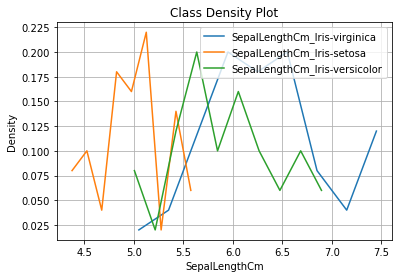

In [13]:
# Converting to Pandas dataframe --- Just to check
pd_df = df1.toPandas()
print(pd_df.shape)
print(pd_df.head())

# Plotting the Pandas dataframe --- Just to check

x1 = pd_df['SepalLengthCm_Iris-virginica'].tolist()
y1 = pd_df['Density_Iris-virginica'].tolist()

x2 = pd_df['SepalLengthCm_Iris-setosa'].tolist()
y2 = pd_df['Density_Iris-setosa'].tolist()

x3 = pd_df['SepalLengthCm_Iris-versicolor'].tolist()
y3 = pd_df['Density_Iris-versicolor'].tolist()

fig, ax = plt.subplots()
ax.plot(x1, y1, label='SepalLengthCm_Iris-virginica')
ax.plot(x2, y2, label='SepalLengthCm_Iris-setosa')
ax.plot(x3, y3, label='SepalLengthCm_Iris-versicolor')

ax.set(xlabel='SepalLengthCm', ylabel='Density', title='Class Density Plot')
ax.legend(loc=1)
ax.grid()

# fig.savefig("test.png")
plt.show()